In [1]:
import librosa
import numpy as np
import sys
import pickle
import time
import IPython.display as ipd
import scipy.signal as signal
from scipy.fftpack import fft, ifft, dct, idct
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import CosineTransformTools as ctt 
from dahuffman import HuffmanCodec

In [2]:
def powerlaw_quant(x, mu):
    return np.sign(x)*np.log(1 + mu*np.abs(x))/np.log(1 + mu)
#     return np.sign(x)*np.amax(x)*np.log(1 + mu*np.abs(x)/np.amax(x))/np.log(1 + mu)

def inv_powerlaw_quant(y, mu):
#     return np.sign(y)*(x_max/mu)*(10**(np.abs(y)*np.log(1+mu)/x_max) - 1)
    return np.sign(y)*((mu + 1)**np.abs(y) - 1)/mu

In [3]:
def quantize(x, S):
    X = x.reshape((-1,1))
    S = S.reshape((1,-1))
    dists = abs(X-S)
    
    nearestIndex = dists.argmin(axis=1)
    quantized = S.flat[nearestIndex]
    
    return quantized.reshape(x.shape)

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=10):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=10):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
def signal_to_noise(original, decoded):
    original = original.astype('float_')
    decoded = decoded.astype('float_')
    diff = len(original) - len(decoded)
    
    if diff < 0:
        decoded = decoded[:diff]
    if diff > 0:
        decoded = np.append(decoded, np.zeros((diff,1)))
        
    signal = np.power(original, 2)
    noise = np.power(original-decoded, 2)
    
    signal = np.where(signal == 0, np.finfo(np.float32).eps, signal)
    noise = np.where(noise == 0, np.finfo(np.float32).eps, noise)
    
    return np.mean(np.log10(signal/noise)*10)

In [6]:
def absolute_threshold_hearing(f):
    return 3.64*np.float_power(f/1000, -0.8) - \
        6.5*np.exp(-0.6*np.power(f/1000 - 3.3, 2)) + \
        np.float_power(10, -3)*np.power(f/1000, 4)

def bark(f):
    return 13*np.arctan(0.00076*f) + 3.5*np.arctan((f/7500)**2)

In [7]:
def load_cd_quality_audio(filename):
    audio, sr = librosa.load(filename, sr=44100, dtype='float_')
    max_int_value = 2**15 - 1
    audio *= max_int_value
    audio = audio.astype('int16')
    return audio, sr
    
x, sr = load_cd_quality_audio("taxman.wav")
fs = 44100

In [8]:
# # ipd.Audio(x, rate=44100)
# x = x[0:1000000]
# x.shape

In [9]:
def divide_into_frames(signal, npoints):
    # Find out how many frames are needed
    nwholeframes = np.floor(len(signal)/npoints).astype('int')
    nframes = np.ceil(len(signal)/npoints).astype('int')
    # Pad the signal so that its length is divisible by nframes
    padded = np.pad(signal, (0, npoints-len(signal)%nwholeframes), 'constant', constant_values=0.0)
    # Reshape padded signal into nframes rows, each row is one frame
    frames = padded.reshape((nframes, len(padded)//nframes))
    return frames

npoints = 1152
nbands = 32
nsubbands = 18

# Divide original signal into frames, each frame consists of npoints
x_frames = divide_into_frames(x, npoints)
x_frames.shape

(6084, 1152)

In [10]:
dt = 1.0 / sr
   
k = np.arange(npoints // 2 + 1)
f_k = k * sr / npoints
b_k = bark(f_k)

k_i = np.r_[1:49, 49:97:2, 97:255:4, 255:513:8]
f_i = k_i * sr / npoints
b_i = bark(f_i)
ATH_i = absolute_threshold_hearing(f_i)
subband_i = np.array([int(s) for s in np.round(f_i * nbands / (0.45 * sr) - 0.5)])

In [11]:
subband_i

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
        9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13,
       13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 17, 17, 18, 18,
       19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27,
       27, 28, 28, 29, 29, 30, 30, 31, 31])

In [12]:
bit_allocation_table = np.array([10, 10, 10, 10, 9, 9, 9, 8, 8, 8, 8, \
                   8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, \
                   4, 4, 4, 4, 4, 4])

In [13]:
class Classifier(object):
    def __init__(self):
        small  = np.array([-2, +2])
        medium = np.array([-3, -2, +2, +3]) 
        large  = np.array([-6, -5, -4, -3, -2, +2, +3, +4, +5, +6])
        xlarge  = np.linspace(-12, 12, 25, dtype='int')
        self.neighbourhood = 512 * [None]
        for _k in range(2, 63):
            self.neighbourhood[_k] = small
        for _k in range(63, 127):
            self.neighbourhood[_k] = medium
        for _k in range(127, 255):
            self.neighbourhood[_k] = large
        for _k in range(255, 501):
            self.neighbourhood[_k] = xlarge
    def __call__(self, k, P):
        k_t = []
        P_t = []
        for _k in np.arange(3, 501):
            if (P[_k-1] <= P[_k] and P[_k+1] <= P[_k]):
                js = self.neighbourhood[_k]
                if np.all(P[_k] - P[_k+js] >= 7):
                    k_t.append(_k)
                    P_t.append(P[_k-1] + P[_k] + P[_k+1])
                    P[_k-1] = P[_k] = P[_k+1] = 0.0
        return (np.array(k_t, dtype='uint16'), np.array(P_t)), (k, P)        

classify = Classifier()

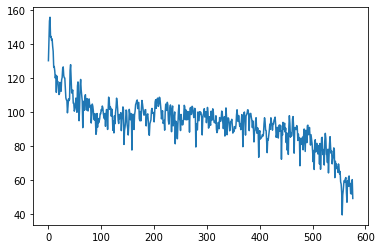

In [14]:
def P_k_from_frame(frame, window, N, dB=True):
    alpha = 1.0 / np.sqrt(sum(window(N)**2) / N)
    frame = alpha * window(N) * frame

    frame_fft_2 = abs(fft(frame)) ** 2

    P_k = 2.0 * frame_fft_2[:(N // 2 + 1)] / N ** 2
    P_k[0] = 0.5 * P_k[0]
    if (N % 2 == 0):
        P_k[-1] = 0.5 * P_k[-1]

    P_k = 10.0 ** (96.0 / 10.0) * P_k
    if dB:
        P_k = 10.0 * np.log10(P_k)  
    return P_k

plt.plot(P_k_from_frame(x_frames[100], signal.windows.hann, 1152))

In [15]:
def group_by_critical_band(k, P):
    b_k = bark(f_k)
    cb_k = np.array([int(b) for b in np.floor(b_k)])
    bands = [[[], []] for _ in np.arange(np.amax(cb_k) + 1)]
    for _k, _P in zip(k, P):
        band = bands[cb_k[_k]]
        band[0].append(_k)
        band[1].append(_P)
    for b, band in enumerate(bands):
        bands[b] = np.array(band)
    return bands

def merge_tonals(k_t, P_t):
    bands = group_by_critical_band(k_t, P_t)
    k_t_out, P_t_out = [], []
    for band, k_P_s in enumerate(bands):
        if len(k_P_s[0]):
            k_max = None
            P_max = - np.inf 
            for _k, _P in zip(*k_P_s):
               if _P > P_max:
                   k_max = _k
                   P_max = _P
            k_t_out.append(k_max)
            P_t_out.append(P_max)
    return np.array(k_t_out, dtype='uint16'), np.array(P_t_out)

def merge_non_tonals(k_nt, P_nt):
    bands = group_by_critical_band(k_nt, P_nt)
    k_nt_out = np.zeros(len(bands), dtype='uint8')
    P_nt_out = np.zeros(len(bands))
    for band, k_P_s in enumerate(bands):
        if len(k_P_s[0]):
            k, P = k_P_s
            P_sum = sum(P)
            if P_sum == 0.0:
                P = np.ones_like(P)
            k_mean = int(round(np.average(k, weights=P))) 
            k_nt_out[band] = k_mean
            P_nt_out[band] = P_sum
    return k_nt_out, P_nt_out

def threshold(k, P):
    ATH_k = 10 ** (absolute_threshold_hearing(f_k) / 10.0)
    k_out, P_out = [], []
    for (_k, _P) in zip(k, P):
        if _P > ATH_k[_k]:
            k_out.append(_k)
            P_out.append(_P)
    return np.array(k_out), np.array(P_out)

def excitation_pattern(b, b_m, I_m, tonal):
    db = b - b_m
    db_1 = np.minimum(db + 1.0, 0.0)
    db_2 = np.minimum(db      , 0.0)
    db_3 = np.maximum(db      , 0.0)
    db_4 = np.maximum(db - 1.0, 0.0)    
    mask  = I_m \
          + (11.0 - 0.40 * I_m) * db_1 \
          + ( 6.0 + 0.40 * I_m) * db_2 \
          - (17.0             ) * db_3 \
          + (       0.15 * I_m) * db_4
    if tonal:
        mask += -1.525 - 0.275 * b - 4.5
    else:
        mask += -1.525 - 0.175 * b - 0.5
    return mask

In [16]:
def maskers(frame, merge=True, ATH_threshold=True):
    P_k = P_k_from_frame(frame, signal.windows.hann, 1152)
    (k_t, P_t), (k_nt, P_nt) = classify(k, P_k)
    if merge:
        k_t, P_t = merge_tonals(k_t, P_t)
        k_nt, P_nt = merge_non_tonals(k_nt, P_nt)
    if ATH_threshold:
        k_t, P_t = threshold(k_t, P_t)
        k_nt, P_nt = threshold(k_nt, P_nt)
    return (k_t, P_t), (k_nt, P_nt)

# maskers(x_frames[500])

In [17]:
def SMR_from_frame(frame):
    frame = np.array(frame, copy=False)

    mask_i = 10.0 ** (ATH_i / 10.0)

    (k_t, P_t), (k_nt, P_nt) = maskers(frame)

    for masker_index in np.arange(len(k_t)):
        _b, _P = b_k[ k_t[masker_index] ], P_t[ masker_index ]
        ep = excitation_pattern(b_i, b_m=_b, I_m=10.0*np.log10(_P), tonal=True)
        mask_i += 10.0 ** (ep / 10.0)

    for masker_index in np.arange(len(k_nt)):
        _b, _P = b_k[k_nt[masker_index]], P_nt[masker_index]
        ep = excitation_pattern(b_i, b_m=_b, I_m=10.0*np.log10(_P), tonal=False) 
        mask_i += 10.0 ** (ep / 10.0)

    mask_i = 10.0 * np.log10(mask_i)

    subband_masks = [[] for _ in range(32)] 
    subband_MMT = np.zeros(32) # MMT = Minimum Masking Threshold
    subband_LSB = np.zeros(32) # LSB = Sound Pressure Level
    subband_SMR = np.zeros(32) # SMR = Signal To Mask Ratio

    for i, _mask_i in enumerate(mask_i):
        subband_masks[subband_i[i]].append(_mask_i)

    for i, _masks in enumerate(subband_masks):
        subband_MMT[i] = np.amin(_masks)

    P_k = P_k_from_frame(frame, signal.windows.hann, 1152)
    for i, _masks in enumerate(subband_MMT):
        max_scalefactor = 20*np.log10((2**bit_allocation_table[i]-1)*32768)-10
        subband_LSB[i] = np.maximum(np.max(P_k), max_scalefactor)

    subband_SMR = subband_LSB - subband_MMT
    
    return np.clip(subband_SMR, 0, None)

# SMR_from_frame(x_frames[100])

In [18]:
def psychoacoustic_analysis(x_frames, nbands):
    SMR = np.zeros((x_frames.shape[0], nbands))
    for i in range(0, x_frames.shape[0]):
        if np.any(x_frames[i]):
            SMR[i,:] = SMR_from_frame(x_frames[i])
        else:
            SMR[i,:] = np.zeros(nbands)
    
    return SMR

t1 = time.time()
x_SMR = psychoacoustic_analysis(x_frames, nbands)
print(time.time() - t1)

/home/sweet/2-coursework/434eces/labs/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in float_power
  This is separate from the ipykernel package so we can avoid doing imports until


35.881993532180786


In [19]:
window_length = 96
window_function = np.sin(np.pi / 2 * \
                       np.power(np.sin(np.pi / window_length * \
                       np.arange(0.5, window_length + 0.5)), 2))
num_blocks = 38

In [20]:
from PQMFB import *
def filter_banks(frames, nbands, num_blocks):
#     fb=np.sin(np.pi/(2*32)*(np.arange(int(1.5*32))+0.5))
#     fb = np.concatenate((fb,np.flipud(fb)))
    x_bands = np.zeros((nbands, frames.shape[0], num_blocks))
    for i in range(0, frames.shape[0]):
        x_bands[:,i,:] = PQMFBana(frames[i], nbands, window_function)
    
    return x_bands

t1 = time.time()
x_bands = filter_banks(x_frames, nbands, num_blocks)
print(time.time() - t1)
x_bands.shape

4.879557847976685


(32, 6084, 38)

In [21]:
class QuantizedFrame(object):
    def __init__(self, scaling_factors=np.array([]), data=np.array([], dtype='int8')):
        self.scaling_factors = scaling_factors
        self.data = data


In [22]:
def quantization(x_bands, x_SMR, nbands, nsubbands):
    x_SMR = x_SMR.astype('int')
    max_bits = np.amax(bit_allocation_table)
    SMR_arr = np.arange(np.amin(x_SMR), np.amax(x_SMR)+1)
    SMR_to_bits = np.round(SMR_arr/(np.amax(x_SMR) / max_bits)).astype('uint8')
    SMR_to_mu = SMR_arr*(-255/np.amax(x_SMR)) + 255

    quantized_signal = []
    frame_separator = 2**(max_bits+1)
    for i in range(0, x_bands.shape[1]):
        quantfr = QuantizedFrame()
        for j in range(0, nbands):
            band_smr = x_SMR[i,j]
            bit_alloc = SMR_to_bits[band_smr]
    #         print(bit_alloc)
            if bit_alloc > 6:
                quantized_mdct = powerlaw_quant(x_bands[j,i,:], 255)/band_smr
    #             print(signal_to_noise(x_subbands[j,i,:], inv_powerlaw_quant(quantized_mdct*band_smr,255)))
                quantized_mdct = quantized_mdct.astype('float16')
                quantfr.data = np.append(quantfr.data, quantized_mdct)
                quantfr.scaling_factors = np.append(quantfr.scaling_factors, band_smr)

        quantized_signal.append(quantfr)
    
    return quantized_signal

t1 = time.time()
quantized_signal = quantization(x_bands, x_SMR, nbands, nsubbands)
print(time.time() - t1)

4.570368051528931


In [23]:
class EncodedSignal(object):
    def __init__(self):
        self.huffman_table_signal = None
        self.signal = []
        self.huffman_table_scaling = None
        self.scaling_factors = []
        self.nframes = 0

In [24]:
def huffman_encoding(quantized_signal):
    encoded_signal = EncodedSignal()
    encoded_signal.nframes = len(quantized_signal)
    for i, frame in enumerate(quantized_signal):
        encoded_signal.signal.extend(frame.data.tolist())
        encoded_signal.signal.append(999999)
        
        encoded_signal.scaling_factors.extend(frame.scaling_factors)
        
    signal_codec = HuffmanCodec.from_data(encoded_signal.signal)
    encoded_signal.huffman_table_signal = signal_codec.get_code_table()
    
    scale_codec = HuffmanCodec.from_data(encoded_signal.scaling_factors)
    encoded_signal.huffman_table_scaling = scale_codec.get_code_table()
    
    encoded_signal.signal = signal_codec.encode(encoded_signal.signal)
    encoded_signal.scaling_factors = scale_codec.encode(encoded_signal.scaling_factors)
    return encoded_signal

encoded_signal = huffman_encoding(quantized_signal)

In [25]:
len(encoded_signal.signal)

7598972

In [26]:
decoded = codec.decode(encoded)
len(decoded)

NameError: name 'codec' is not defined

In [ ]:
def compressionRatio(original, decoded):
    o_str = pickle.dumps(original)
    e_str = pickle.dumps(decoded)
    return sys.getsizeof(o_str)/sys.getsizeof(e_str)

compressionRatio(x,encoded_signal)

In [ ]:

# def decode(encoded_signal):
signal_decoder = HuffmanCodec(code_table=encoded_signal.huffman_table_signal, check=False)
scaling_decoder = HuffmanCodec(code_table=encoded_signal.huffman_table_scaling, check=False)
decoded_signal = np.array(signal_decoder.decode(encoded_signal.signal))
decoded_scaling = np.array(signal_decoder.decode(encoded_signal.scaling_factors))

empty_frame = np.array([0]*npoints)
mdct_per_frame = num_blocks
decoded_final = np.zeros((encoded_signal.nframes, npoints))
frame_separator = 999999

frame_no = 0
scale_no = 0
for i in range(0, len(decoded_signal)-1):
    if decoded_signal[i] == frame_separator and decoded_signal[i+1] == frame_separator:
        decoded_final[frame_no,:] = empty_frame
        frame_no += 1
        continue
    if decoded_signal[i] == frame_separator:
        decoded_mdct = np.zeros((nbands, num_blocks))
#         frame_data = np.array(huffman_decoder.decode(frame.data))
    #     print(frame_data)
        idx = i
        for j in range(0, 32):
            if decoded_signal[end+1] != frame_separator:
                idx = i + j
                scale_factor = decoded_scaling[scale_no]
                scale_no += 1
                start = i+1+j*mdct_per_frame
                end = i+1+(j+1)*mdct_per_frame
                encoded_mdct = decoded_signal[start:end]*scale_factor
                decoded_mdct[j] = inv_powerlaw_quant(encoded_mdct, 255)
        i = idx
        decoded_frame = PQMFBsyn(decoded_mdct, window_function)

        diff = 1152 - len(decoded_frame)
        if diff < 0:
            decoded_final[frame_no,:] = decoded_frame[:diff]
        if diff > 0:
            decoded_final[frame_no,:] = np.append(decoded_frame, np.zeros((diff,1)))
        frame_no += 1

# return decoded_signal

t1 = time.time()
# decoded_signal = decode(encoded_signal)
print(time.time() - t1)

In [ ]:
#     alpha_value = 5
#     Kaiser-Bessel-derived (KBD) window as used in the AC-3 audio coding format
#     window_function = np.kaiser(int(window_length/2)+1, alpha_value*np.pi)
#     window_function2 = np.cumsum(window_function[0:int(window_length/2)])
#     window_function = np.sqrt(np.concatenate((window_function2, window_function2[int(window_length/2)::-1]))
#                               / np.sum(window_function))
# window_length = 128
# # window_function = np.sin(np.pi / 2 * np.power(np.sin(np.pi / window_length * np.arange(0.5, window_length + 0.5)), 1))
# window_function = np.sin(np.pi/(2*576)*(np.arange(int(1.5*576))+0.5))

# plt.plot(window_function)

# tmp_mdct = ctt.mdct(x_bands[0,500,:], window_function)
# tmp_imdct = ctt.imdct(tmp_mdct, window_function)
# tmp_mdct.shape
total*38

In [ ]:
signal_to_noise(x, decoded_signal.flatten())

In [ ]:
ipd.Audio(decoded_signal.flatten(), rate=44100)

In [ ]:
# decoded_signal[100:]